In [26]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
datos, metadatos = tfds.load('fashion_mnist', as_supervised= True, with_info= True)

In [5]:
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='C:\\Users\\Lenovo\\tensorflow_datasets\\fashion_mnist\\3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
  

In [6]:
datos_entrenamiento, datos_pruebas =datos['train'], datos['test']

In [7]:
nombres_clases= metadatos.features['label'].names

In [8]:
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [9]:
#NORMALIZAR los datos (Pasar de 0-255 a 0-1)

def normalizar(imagenes,etiquetas):
    imagenes= tf.cast(imagenes, tf.float32)
    imagenes /= 255 #Aqui lo pasa de 0-255 a 0-1
    return imagenes, etiquetas
    

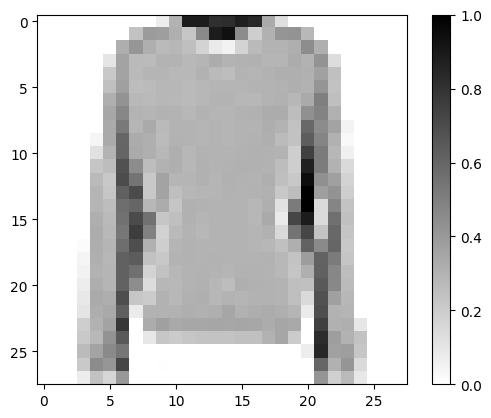

In [10]:
# Normalizar los datos de entrenamiento y pruebas con la función que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar, num_parallel_calls=tf.data.experimental.AUTOTUNE)
datos_pruebas = datos_pruebas.map(normalizar, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Agregar a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

# Mostrar una imagen de los datos de pruebas, de momento mostremos la primera
for imagen, etiqueta in datos_entrenamiento.take(1):
    imagen = imagen.numpy().reshape((28,28)) # Redimensionar la imagen
    plt.figure()
    plt.imshow(imagen, cmap=plt.cm.binary)
    plt.colorbar()
    plt.grid(False)
    plt.show()

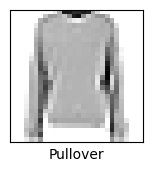

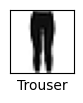

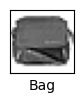

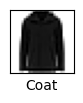

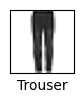

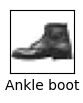

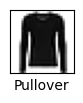

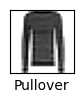

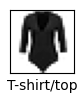

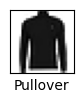

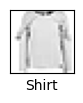

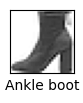

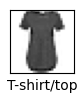

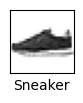

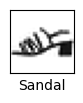

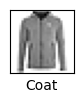

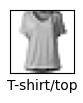

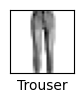

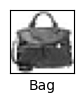

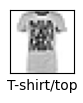

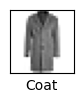

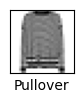

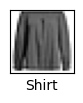

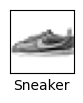

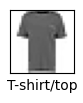

In [11]:
plt.figure(figsize=(10,10))
for i,(imagen,etiqueta)in enumerate(datos_entrenamiento.take(25)):
    imagen=imagen.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagen,cmap=plt.cm.binary)
    plt.xlabel(nombres_clases[etiqueta])
    plt.show()

In [12]:
#Crear el modelo

modelo= tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)), #1 -blanco y negro
    tf.keras.layers.Dense(50,activation=tf.nn.relu),
    tf.keras.layers.Dense(50,activation=tf.nn.relu),
    tf.keras.layers.Dense(10,activation=tf.nn.softmax) #Para redes de clasificacion
])

In [13]:
#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [14]:
num_ej_entrenamiento=metadatos.splits["train"].num_examples
num_ej_pruebas =metadatos.splits["test"].num_examples

In [15]:
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [16]:
TAMANO_LOTE = 32
datos_entrenamiento= datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas=datos_pruebas.batch(TAMANO_LOTE)

In [17]:
import math
#Entrenar
historial=modelo.fit(datos_entrenamiento,epochs=5,steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

Epoch 1/5



1875/1875 [==============================] - 8s 2ms/step - loss: 0.5268 - accuracy: 0.8144
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3865 - accuracy: 0.8619
Epoch 3/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3520 - accuracy: 0.8711
Epoch 4/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3274 - accuracy: 0.8806
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3076 - accuracy: 0.8874


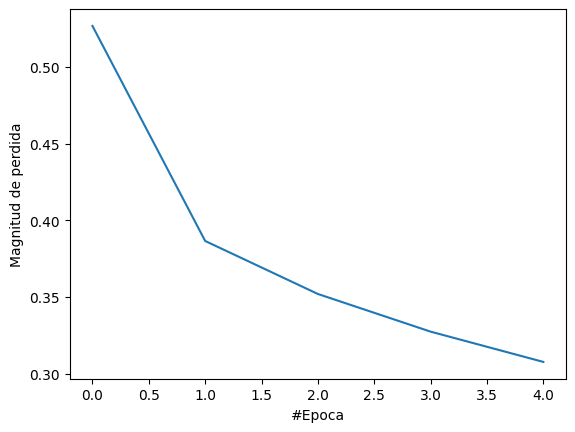

In [18]:
plt.xlabel("#Epoca")
plt.ylabel("Magnitud de perdida")
plt.plot(historial.history["loss"])


In [19]:
import numpy as np

1/1 [==============================] - 0s 184ms/step


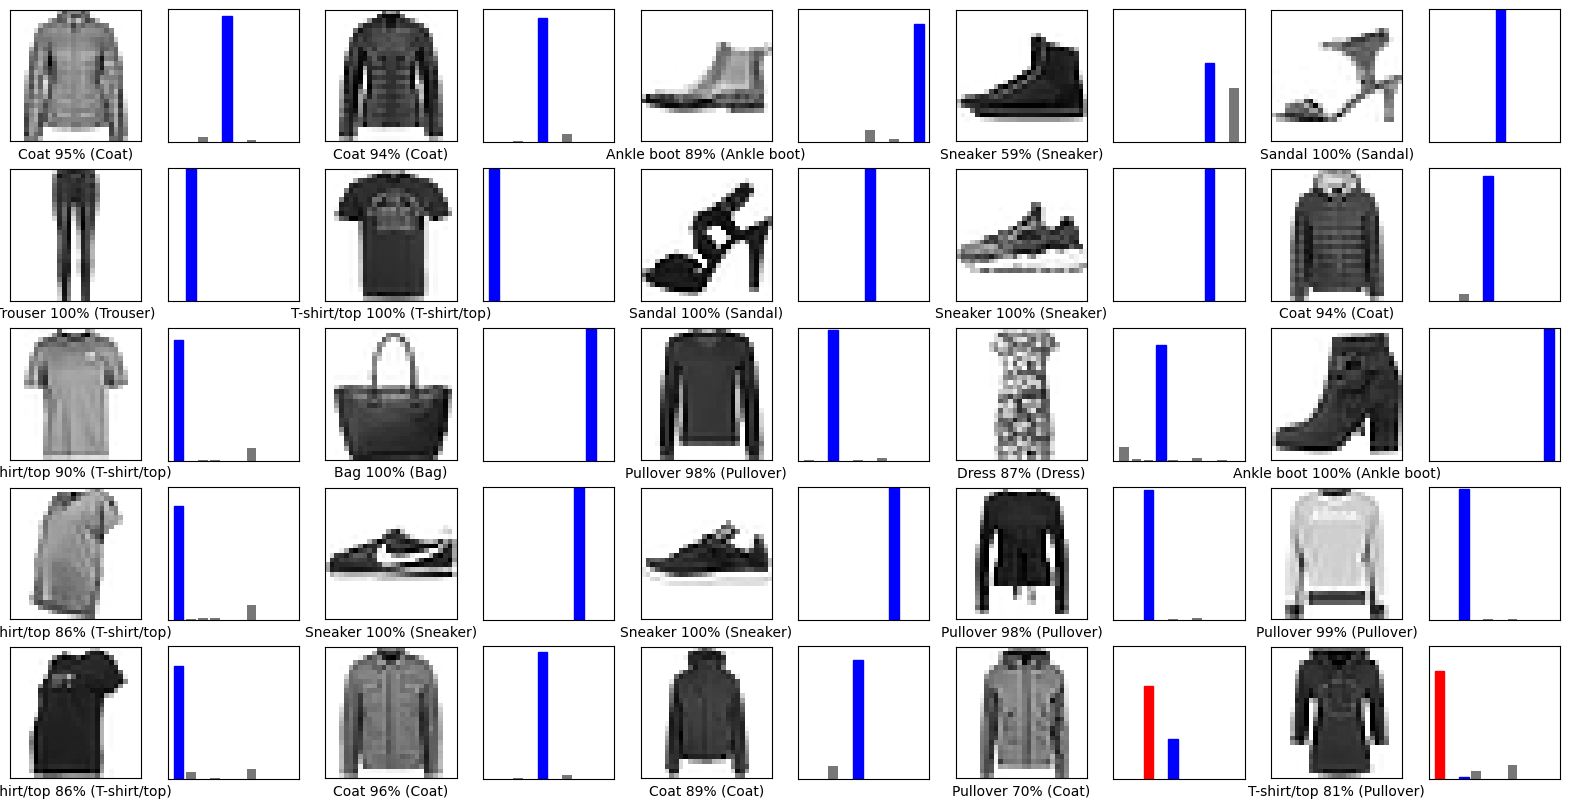

In [20]:

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
    imagenes_prueba=imagenes_prueba.numpy()
    etiquetas_prueba=etiquetas_prueba.numpy()
    predicciones=modelo.predict(imagenes_prueba)
def graficar_imagen(i,arr_predicciones, etiquetas_reales, imagenes):
    arr_predicciones,etiqueta_real,img=arr_predicciones[i],etiquetas_reales[i],imagenes[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[...,0], cmap=plt.cm.binary)

    etiqueta_prediccion= np.argmax(arr_predicciones)
    if etiqueta_prediccion ==etiqueta_real:
        color='blue' #Si le atino
    else:
        color='red' #Oops, no le atino
    plt.xlabel("{} {:2.0f}% ({})".format(
        nombres_clases[etiqueta_prediccion],
        100*np.max(arr_predicciones),
        nombres_clases[etiqueta_real],
        color=color
    ))
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
    arr_predicciones, etiqueta_real=arr_predicciones[i], etiqueta_real[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    grafica= plt.bar(range(10), arr_predicciones,color="#777777")
    plt.ylim([0,1])
    etiqueta_prediccion= np.argmax(arr_predicciones)

    grafica[etiqueta_prediccion].set_color('red')
    grafica[etiqueta_real].set_color('blue')

filas= 5
columnas=5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
    plt.subplot(filas, 2*columnas, 2*i+1)
    graficar_imagen(i,predicciones, etiquetas_prueba, imagenes_prueba)
    plt.subplot(filas, 2*columnas, 2*i+2)
    graficar_valor_arreglo(i,predicciones,etiquetas_prueba)
    

In [21]:
#Tomar cualquier indice del set de pruebas para ver su prediccion
imagen=imagenes_prueba[10]
imagen=np.array([imagen])
prediccion=modelo.predict(imagen)

print("Prediccion: "+nombres_clases[np.argmax(prediccion[0])])

1/1 [==============================] - 0s 96ms/step
Prediccion: T-shirt/top


In [ ]:
#Exportacion del modelo
modelo.save('modelo_exportado.h5')

In [ ]:
#Instalar tensorflowjs
!pip install tensorflowjs --user

In [25]:
import os
import subprocess

# Nombre del directorio
directory_name = "tfjs_target_dir"

# Crear el directorio tfjs_target_dir
os.makedirs(directory_name, exist_ok=True)

# Convertir el archivo h5 a formato de TensorFlow.js
subprocess.run(["tensorflowjs_converter", "--input_format", "keras", "C:\\Users\\Lenovo\\modelo_exportado.h5", directory_name])





FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado